## Statistical Test

From the exploratory analysis, we identify that sales tend to fluctuate by month and day of week, both of which are time-series components. We will access the time-series nature of the data to ensure it follows certain properties since any time-series predictive models will rely on that.

In [1]:
from datetime import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import acf, adfuller
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA, ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline 

In [2]:
train_df = pd.read_csv('data/train_df.csv', parse_dates=['date'])

In [3]:
train_df.head()

,date,date_block_num,shop_id,shop_name,item_id,item_name,item_category_id,item_category_name,item_price,item_cnt_day,sales
0,2013-01-02,0,59,"Ярославль ТЦ ""Альтаир""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
1,2013-01-02,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
2,2013-01-03,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
3,2013-01-20,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0
4,2013-01-23,0,25,"Москва ТРК ""Атриум""",22154,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,999.0


In [4]:
ts_data = train_df[['date','sales']]

In [5]:
ts_daily = ts_data.groupby(['date'])['sales'].sum()

In [6]:
ts_weekly = ts_daily.resample(rule='W').last()
ts_monthly = ts_daily.resample(rule='M').last()

## Modeling

### Simple ARMA model

We will start with model order 1 to get a naive based model predictions on sales. We split the dataset into train (Jan 2013 - Jul 2015) and test (Aug 2015 - Oct 2015).

In [19]:
ttl_period = len(ts_weekly)
pred_period = 12
ts_train = ts_weekly[:-pred_period]
ts_test = ts_weekly[-pred_period:]

In [20]:
mod = ARMA(ts_train, order=(1,0))
res = mod.fit()
prediction = res.predict(start=ts_test.index[0], end=ts_test.index[-1])

In [21]:
comparsion = pd.DataFrame({'predict': prediction, 'test': ts_test})

In [22]:
print('RMSE is {:,.0f}'.format(mean_squared_error(ts_test, prediction)))

RMSE is 546,217,502,118


Above is the 1st order model result. We will find the optimal order(s) that will lead to the minimal BIC

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


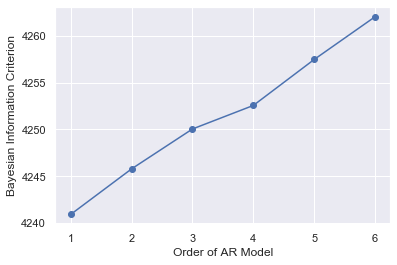

In [23]:
BIC = np.zeros(7)
for p in range(7):
    mod = ARMA(ts_train, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

AR = 1 is the best parameter. We repeat the same process for finding MA, with AR already set at 1

Using trial and error, it turns out MA=2 will result in the lowest RSME

In [24]:
mod_1 = ARMA(ts_train, order=(1,2))
res_1 = mod_1.fit()
prediction_1 = res_1.predict(start=ts_test.index[0], end=ts_test.index[-1])
print('RMSE is {:,.0f}'.format(mean_squared_error(ts_test, prediction_1)))

RMSE is 370,080,391,659


RSME dropped by 35% when MA order is added to the model

Final step is to integrate the ARMA into ARIMA

In [25]:
mod_2 = ARIMA(ts_train, order=(1,1,2))
res_2 = mod_2.fit()
prediction_2 = res_2.predict(start=ts_test.index[0], end=ts_test.index[-1])
print('RMSE is {:,.0f}'.format(mean_squared_error(ts_test, prediction_2)))

RMSE is 8,650,559,485,142


In [26]:
comparsion = pd.DataFrame({'predict': prediction, 'predict_1': prediction_1, 'predict_2': prediction_2, 'test': ts_test})

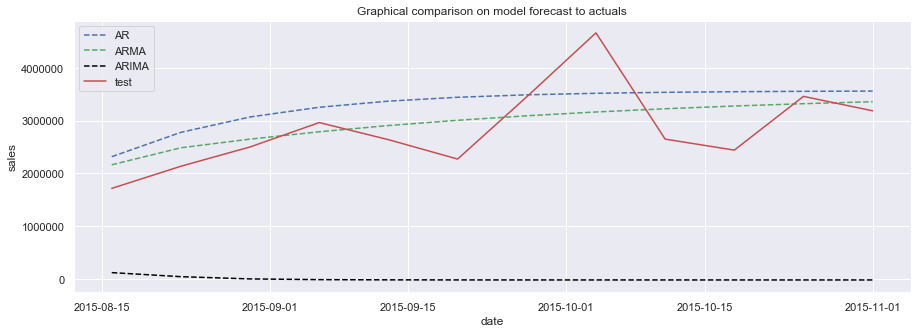

In [27]:
plt.figure(figsize=(15,5))
plt.plot(comparsion['predict'], color='b', linestyle='dashed', label='AR')
plt.plot(comparsion['predict_1'], color='g', linestyle='dashed', label='ARMA')
plt.plot(comparsion['predict_2'], color='black', linestyle='dashed', label='ARIMA')
plt.plot(comparsion['test'], color='r', label='test')
plt.title('Graphical comparison on model forecast to actuals')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

#### Model Comparison

In [28]:
model = pd.DataFrame({'model': ['AR', 'ARMA', 'ARIMA'], 
                      'RMSE': [mean_squared_error(ts_test, prediction), mean_squared_error(ts_test, prediction_1), mean_squared_error(ts_test, prediction_2)],
                     'AIC+BIC':[(res.aic+res.bic), (res_1.aic+res_1.bic), (res_2.aic+res_2.bic)]})

In [29]:
model.set_index('model')

,RMSE,AIC+BIC
model,,
AR,5.462175e+11,8500.780393
ARMA,3.700804e+11,8483.700826
ARIMA,8.650559e+12,8430.807331


### Observations

ARMA has the smallest RMSE. AIC+BIC scores across all models are similar.

### Next Steps

Perform time based cross validation, using expanding and sliding windows. We will also apply other time series model such as Prophet, Multivariate Time Series Model, and Regime Switching Model.

#### Cross validations

In [30]:
# Define a function for the ARIMA model train and RSME generation
# This function is accessing RSME for predicting 10 weeks out forecast with expanding data window
def arima_rsme(data_set, n):
    a = data_set[:-n]
    b = data_set[-n:-n+10]
    mod = ARIMA(a, order=(1,0,2))
    res = mod.fit()
    pred = res.predict(start=b.index[0], end=b.index[-1])
    rmse = mean_squared_error(b, pred)
    return rmse

In [31]:
# testing function
print('RMSE is {:,.0f}'.format(arima_rsme(ts_weekly, 15)))

RMSE is 866,933,942,687


In [32]:
for i in [60, 48, 36, 24, 12]:
    print('10 weeks out RMSE is {:.0f}'.format(arima_rsme(ts_weekly,i)))

10 weeks out RMSE is 2451456850311
10 weeks out RMSE is 11122880923626
10 weeks out RMSE is 1997357797641
10 weeks out RMSE is 1856090303743
10 weeks out RMSE is 439209562347


The RSME continue to get larger as the train set size decrease on predicting 10 weeks out forecast. It could mean that current dataset does not provide ARIMA model enough data point to have consistent performance, or the data are not very stationary afterall.

## Prophet

The model works well with continuous time data. We will switch apply the daily level data set to the model

In [33]:
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

In [34]:
prophet_df = ts_daily.reset_index()
prophet_df.columns = ['ds','y']
prophet_df.head()

,ds,y
0,2013-01-01,1362942.00
1,2013-01-02,6020512.03
2,2013-01-03,5436480.11
3,2013-01-04,4755664.00
4,2013-01-05,4587231.00


In [35]:
prophet_df.ds = pd.to_datetime(prophet_df.ds)
prophet_df.y = prophet_df.y.astype('float')

In [36]:
prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 2 columns):
ds    1034 non-null datetime64[ns]
y     1034 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.2 KB


In [37]:
pred_size = 30
train_df = prophet_df[:-pred_size]

In [ ]:
m = Prophet()

In [ ]:
m.fit(train_df)

In [ ]:
future = m.make_future_dataframe(periods=pred_size, freq='W')
pred = m.predict(future)

In [ ]:
pred.head()